<a href="https://colab.research.google.com/github/xBrymer/Clock-Cipher/blob/master/DogsVsCats_v3_0%20-%20working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing the images



In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [9]:
#GOOGLE DRIVE DIRECTORIES

TRAIN_DIR = "/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats/train"
TRAIN_CATS_DIR = "/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats/Train/Cats"
TRAIN_DOGS_DIR = "/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats/Train/Dogs"

TEST_DIR = "/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats/test1"
MAIN_DIR = "/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats/Train"

In [ ]:
print(len(os.listdir(TRAIN_DIR)))

0


In [ ]:
def class_image(image):
  label = image.split('.')[0]
  if label == 'cat': return 0
  elif label == 'dog': return 1

In [ ]:
def move_images():
  for image in tqdm(os.listdir(TRAIN_DIR)):
    if class_image(image) == 0:
      shutil.move(f'{TRAIN_DIR}/{image}', f'{TRAIN_CATS_DIR}/{image}' )
    elif class_image(image) == 1:
      shutil.move(f'{TRAIN_DIR}/{image}', f'{TRAIN_DOGS_DIR}/{image}')
  return

In [10]:
cd /content/gdrive/My Drive/External Datasets/Kaggle

/content/gdrive/My Drive/External Datasets/Kaggle


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/External Datasets/Kaggle"

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip \*.zip  && rm *.zip

In [ ]:
os.mkdir('/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats/Train/Dogs')

In [ ]:
move_images()

**Moving files to local storage to use TPU in Google Colab**





In [ ]:
os.mkdir('/home/Datasets')

In [2]:
TEMP_DIR = '/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats'
WORK_DIR = '/home/Datasets/Dogs-Vs-Cats'



In [3]:
# LOCAL DIRECTORIES (NEEDED TO WORK FOR TPU)

MAIN_DIR = '/home/Datasets/Dogs-Vs-Cats'

TRAIN_DIR = '/home/Datasets/Dogs-Vs-Cats/Train'
CATS_DIR = '/home/Datasets/Dogs-Vs-Cats/Train/Cats'
DOGS_DIR = '/home/Datasets/Dogs-Vs-Cats/Train/Dogs'

In [5]:
def dog_images():
  for image in tqdm(os.listdir(f'{TEMP_DIR}/Train/Dogs')):
    if image not in os.listdir(DOGS_DIR):
      shutil.copy(f'{TEMP_DIR}/Train/Dogs/{image}',f'{DOGS_DIR}/{image}')
  return

In [6]:
dog_images()

In [7]:
print(len(os.listdir(DOGS_DIR)))

12500


In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [12]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    MAIN_DIR,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)

Found 25000 files belonging to 2 classes.


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy',
  optimizer='adam',metrics=['accuracy'])

  

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

In [20]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
normalized_ds = Dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.99556136


In [132]:

history = model.fit(normalized_ds, epochs = 3)

Epoch 1/3
782/782 [==============================] - 127s 162ms/step - loss: 0.3769 - accuracy: 0.8321
Epoch 2/3
782/782 [==============================] - 125s 160ms/step - loss: 0.3472 - accuracy: 0.8490
Epoch 3/3
782/782 [==============================] - 127s 163ms/step - loss: 0.3051 - accuracy: 0.8706


In [133]:
cd '/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats'

/content/gdrive/My Drive/External Datasets/Kaggle/Dogs-Vs-Cats


In [136]:
model.save('DvC-v3.1.h5')

In [31]:
model.metrics_names

['loss', 'accuracy']

In [137]:

probability_model = tf.keras.Sequential([
  model, tf.keras.layers.Softmax()                   
])

In [44]:
def process_test_images(limit):
  test_images = []
  
  for image in tqdm(os.listdir(TEST_DIR)[:limit]):
       
    image = tf.keras.preprocessing.image.load_img(
        f'{TEST_DIR}/{image}',
        color_mode="rgb",
        interpolation="bilinear",
        target_size=(128, 128)
    )
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.array([image])/255
    image.reshape(128, 128, 3)

    test_images.append(image)

 
  return test_images

In [79]:
TEST_IMAGES = process_test_images(100)

In [81]:
TEST_IMAGES = np.reshape(TEST_IMAGES,(100,128,128,3))

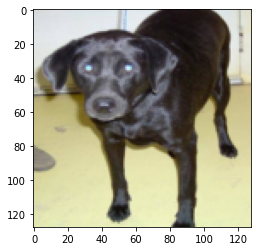

In [83]:
plt.imshow(TEST_IMAGES[5])

In [138]:
predictions = probability_model(TEST_IMAGES)
class_names = ['cat', 'dog']

In [141]:
def predict(index):
  plt.imshow(np.reshape(TEST_IMAGES[index], (128,128,3)))
  print(predictions[index])
  class_prediction = class_names[np.argmax(predictions[index])]
  print()
  print(f'I am {predictions[index][0]*100}% sure that this is a cat')
  print(f'I am {predictions[index][1]*100}% sure that this is a dog')
  print()
  print(f'So, I predict that this is a {class_prediction}')
  return

  return

tf.Tensor([0.7289462 0.2710538], shape=(2,), dtype=float32)

I am 72.89462280273438% sure that this is a cat
I am 27.105379104614258% sure that this is a dog

So, I predict that this is a cat


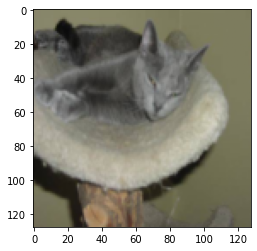

In [155]:
import random

n = random.randint(0,99)

predict(n)